# UNET SEGMENTATION

In [1]:
## Imports
import os
import sys
import random
from glob import glob as glob
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import matplotlib
import matplotlib.image as Image
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Hyperparameters

In [2]:
dim = 224

# get image and mask files
image_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data\*_i*')
mask_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data\*_s*')

# splits into test and training datasets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size = 0.33, random_state= 123)

epochs = 5
batch_size = 20



## Data Generator

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_files, mask_files,  batch_size):
        self.img_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.num_files = len(image_files)


    # def __load__(self, id_name):
    #     ## Path
    #     image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
    #     mask_path = os.path.join(self.path, id_name, "masks/")
    #     all_masks = os.listdir(mask_path)
        
    #     ## Reading Image
        
    #     image = cv2.imread(image_path, 1)
    #     #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #     image = cv2.resize(image, (self.image_size, self.image_size))
        
    #     mask = np.zeros((self.image_size, self.image_size, 1))
        
    #     ## Reading Masks
    #     for name in all_masks:
    #         _mask_path = mask_path + name
    #         _mask_image = cv2.imread(_mask_path, -1)
    #         _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
    #         _mask_image = np.expand_dims(_mask_image, axis=-1)
    #         mask = np.maximum(mask, _mask_image)
                
    #     ## Normalizaing 
    #     image = image/255.0
    #     mask = mask/255.0
        
    #     return image, mask
    
    def __getitem__(self, index):
        'Returns batch of images and labels'

        this_batch = self.batch_size
        # Changes batch size for final batch (no data missed)
        if(index+1)*self.batch_size > self.num_files:
            this_batch = self.num_files - index*self.batch_size
        
        # sets limits for batch
        start = index*self.batch_size
        stop = start + this_batch

        # takes images and masks files within batch
        img_batch = self.img_files[start : stop]
        mask_batch = self.mask_files[start : stop]

        images = []
        masks  = []
        
        # loads images and files and adds them to list
        for i, (img_file, mask_file) in enumerate(zip(img_batch,mask_batch)):
            # Normalises
            img = cv2.imread(img_file) 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
            mask = cv2.imread(mask_file, 0) / 255
            mask = np.array(mask, dtype=int)
            mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
            images.append(img)
            masks.append(mask)
            
        images = np.array(images)
        #image = np.reshape(image, (batch_size, 256, 256, 1))
        masks  = np.array(masks)
        
        
        return images, masks
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        'Returns Number of batches'
        return int(np.ceil(self.num_files // self.batch_size))

In [4]:



# data loader obj is created with training images and masks
gen = DataGen(image_files=train_imgs, mask_files=train_masks, batch_size=batch_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)


(20, 224, 224, 3) (20, 224, 224, 1)


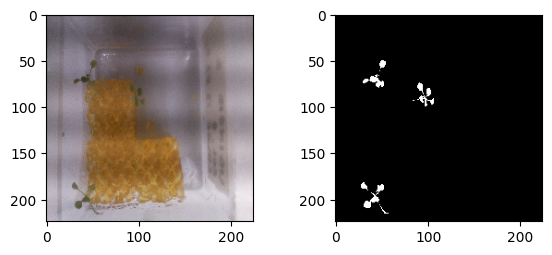

In [5]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (dim, dim)), cmap="gray")

## Different Convolutional Blocks

In [6]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [7]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
model = UNet(dim)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 28, 28,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ up_sampling2d[0]

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [9]:
train_gen = DataGen(train_imgs, train_masks, batch_size= batch_size)
valid_gen = DataGen(test_imgs, test_masks, batch_size=batch_size)


train_steps = train_gen.num_files//batch_size
valid_steps = valid_gen.num_files//batch_size

history = model.fit(train_gen, batch_size=batch_size, epochs = 1, validation_data = valid_gen)

C:\Users\chloe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - acc: 0.5439 - loss: 0.6889 - val_acc: 0.9879 - val_loss: 0.6295


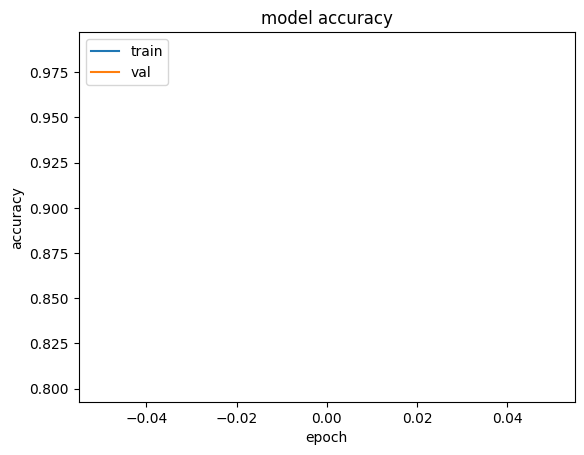

In [10]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

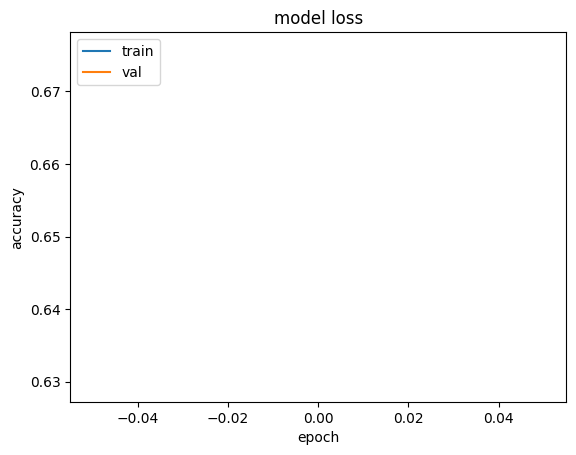

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
print("Max acc:", round(max(history.history['acc']),4))
print("Max val_acc:", round(max(history.history['val_acc']),4))
print("\nMin loss:", round(min(history.history['loss']),4))
print("Min val_loss:", round(min(history.history['val_loss']),4))

Max acc: 0.8021
Max val_acc: 0.9879

Min loss: 0.6759
Min val_loss: 0.6295


## Testing the model

In [13]:
## Save the Weights

#model.save_weights("UNetW.h5")

In [14]:
## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


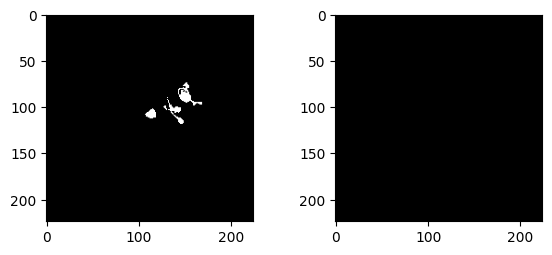

In [15]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (dim, dim)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (dim, dim)), cmap="gray")

In [ ]:
fig = plt.figure()

fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[0]*255, (dim, dim)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (dim, dim)), cmap="gray")

## Save Model

In [ ]:
!mkdir saved_models
model.save(r'C:\Users\thoma\Desktop\CT_Segment_Full_v2.h5')